In [1]:
import GPyOpt, numpy as np, seaborn as sns, matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%run collect_and_name_data.py rnaseq

loading rnaseq data
rnaseq_all_genes: (11216, 104)
rnaseq_effector_genes: (1044, 104)
rnaseq_mod_activities: (89, 104)
rnaseq_mod_genevals: (172, 104)
rnaseq_mod_nodevals: (462, 104)
rnaseq_signaling_genes: (2184, 104)
rnaseq_design: (104, 4)


In [3]:
from sklearn.neighbors import KNeighborsClassifier

In [4]:
KNeighborsClassifier?

In [5]:
from paramz import Model, Param

In [6]:
class ParamzKNN(Model):
    def __init__(self, X, y, neighbours=1., name='ParamzSVC'):
        super(ParamzKNN, self).__init__(name=name)

        self.X = X
        self.y = y
        
        self.neighbours = Param('neighbours', neighbours)
        self.link_parameter(self.neighbours)
        
        self._accuracies = np.empty((10,5))
        
    def parameters_changed(self):
        from sklearn.metrics import f1_score, accuracy_score
        from sklearn.cross_validation import StratifiedKFold
        from sklearn.neighbors import KNeighborsClassifier
    
    
        for i in range(self._accuracies.shape[0]):
            j = 0
            for train_index, test_index in StratifiedKFold(train_labels, shuffle=True, n_folds=self._accuracies.shape[1]):
                classifier = KNeighborsClassifier(n_neighbors=int(self.neighbours), n_jobs=3, algorithm='brute', weights='distance', metric='cosine')
                classifier = classifier.fit(self.X[train_index], self.y[train_index])
                prediction = classifier.predict(self.X[test_index])
                #self._obj += accuracy_score(self.y[test_index], prediction)
                self._accuracies[i,j] = accuracy_score(self.y[test_index], prediction)
                j += 1
                
        self._obj = self._accuracies.mean()

        
    def objective_function(self):
        import numpy as np
        #print self._obj,
        return -np.atleast_1d(self._obj)

In [7]:
train_idx = design.Set == design.Set.unique()[0]
test_idx = ~train_idx    

train_labels = design.loc[train_idx, 'Effect']
test_labels = design.loc[test_idx, 'Effect']

In [8]:
def get_train_test_set(data, train_idx, test_idx):
    train_set = data.loc[:, train_idx].copy()
    from sklearn.preprocessing import StandardScaler
    normalizer = StandardScaler()
    train_set[:] = normalizer.fit_transform(train_set.T).T

    test_set = data.loc[:, test_idx].copy()
    test_set[:] = normalizer.transform(test_set.T).T
    
    return train_set, test_set

In [9]:
def make_f(m):
    def f(X):
        ret = np.empty((X.shape[0],1))
        for i in range(X.shape[0]):
            ret[i] = m._objective(X[i])
        return ret
    return f

In [ ]:
train_errors = {}

for i in range(len(all_data)):
    data = all_data[i]
    print data.name
    train_set, test_set = get_train_test_set(data, train_idx, test_idx)
    
    m = ParamzKNN(train_set.T.values, train_labels.values)
    
    fx_opt = np.inf#m.objective_function()
    x_opt = np.nan#m.param_array.copy()
    
    for k in np.arange(3,20,1):
        m.neighbours = k
        if m.objective_function() < fx_opt:
            fx_opt = m.objective_function()
            x_opt = m.param_array.copy()
    train_errors[data.name] = [fx_opt, x_opt]
    #m_opt = GPyOpt.methods.BayesianOptimization(make_f(m), 
    #                                        bounds=[
    #                                                (np.exp(-5),np.exp(15)),
    #                                                (np.exp(-15),np.exp(5))
    #                                                ], 
    #                                        model_optimize_restarts = 100,
    #                                        normalize=True,
    #                                        acquisition = 'EI',
    #                                        type_initial_design='latin')
    #print
    #m_opt.run_optimization(500, eps=1e-5)
    #print
    #train_errors[data.name] = [m_opt.fx_opt, m_opt.x_opt]

all_genes


In [ ]:
train_errors

In [19]:
results = pd.DataFrame(columns=['acc', 'K'], 
                       index=train_errors.keys(),
                       dtype=float)
acc, cg = zip(*train_errors.values())
results['acc'] = -np.concatenate(acc)
results['K'] = cg

(-0.5, 5.5)

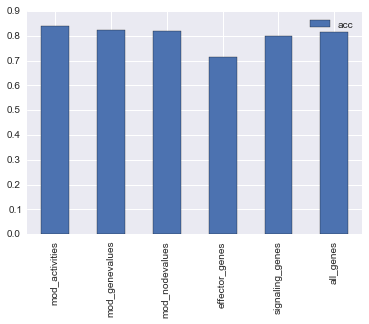

In [20]:
ax = results.plot(kind='bar', y='acc')
ax.set_xlim()

In [21]:
best = results.acc.idxmax(0)
print best

mod_activities


## Work on best training data:

In [15]:
classifier = KNeighborsClassifier(n_neighbors=results.loc[best, 'K'], n_jobs=3)

In [22]:
train_set, test_set = get_train_test_set(rnaseq_mod_activities, train_idx, test_idx)
classifier.fit(train_set.T.values, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=3, n_neighbors=array([ 3.]), p=2,
           weights='uniform')

In [24]:
prediction_probabilities = pd.DataFrame(classifier.predict_proba(test_set.T.values), index=test_set.columns, columns=classifier.classes_)

 /Users/maxz/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:72: DeprecationWarning:using a non-integer number instead of an integer will result in an error in the future
 /Users/maxz/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:72: DeprecationWarning:using a non-integer number instead of an integer will result in an error in the future
 /Users/maxz/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:72: DeprecationWarning:using a non-integer number instead of an integer will result in an error in the future
 /Users/maxz/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:72: DeprecationWarning:using a non-integer number instead of an integer will result in an error in the future
 /Users/maxz/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:72: DeprecationWarning:using a non-integer number instead of an integer will result in an error in the future
 /Users/maxz/an

In [25]:
test_labels.value_counts()
test_labels_collected = test_labels.copy()
test_labels_collected[(test_labels_collected=='Effect_6')+(test_labels_collected=='Effect_7')] = 'Unknown'
#test_labels_collected = pd.get_dummies(test_labels_collected)

## Roc curve for each class:

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [27]:
rocs = {}
for c in prediction_probabilities.columns:
    rocs[c] = roc_curve(test_labels_collected==c, prediction_probabilities[c])

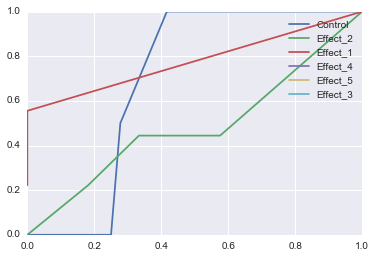

In [28]:
for name in rocs:
    plt.plot(rocs[name][0], rocs[name][1], label=name)
plt.legend()

## Try to use the predicted probabilities to find unknown classes:

In [29]:
def predict_classes(prediction_probabilities, threshold):
    import scipy
    #sort = np.argsort(prediction_probabilities, 1).values[:, ::-1]
    prediction = prediction_probabilities.idxmax(1)
    #score = prediction_probabilities.std(1)
    score = prediction_probabilities.max(1)
    prediction[score<threshold] = 'Unknown'
    return prediction

In [30]:
thresholds = np.linspace(0,1,300)
accs = pd.DataFrame(columns=['acc', 'prec', 'recall'], index=thresholds)
for t in thresholds:
    prediction = predict_classes(prediction_probabilities, t)
    accs.loc[t] = [accuracy_score(test_labels_collected, prediction), precision_score(test_labels_collected, prediction), recall_score(test_labels_collected, prediction)]

 /Users/maxz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning:The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
 /Users/maxz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning:The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
 /Users/maxz/anaconda/lib/python

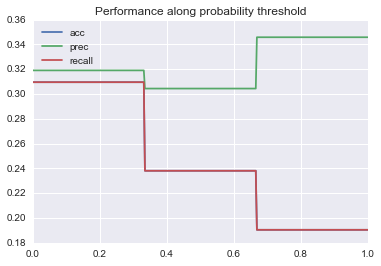

In [31]:
ax = accs.plot()
ax.set_title('Performance along probability threshold')

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
best = prediction_probabilities.idxmax(1)
score = prediction_probabilities.max(1)
best[score<accs.acc.max()] = 'Unknown'

In [34]:
best

RNAseq22     Control
RNAseq23    Effect_2
RNAseq24    Effect_4
RNAseq25    Effect_4
RNAseq26    Effect_2
RNAseq27     Control
RNAseq28    Effect_2
RNAseq29    Effect_2
RNAseq30     Control
RNAseq31     Control
RNAseq32     Control
RNAseq34    Effect_1
RNAseq35     Control
RNAseq36     Control
RNAseq38     Control
RNAseq39    Effect_2
RNAseq40    Effect_2
RNAseq41    Effect_4
RNAseq42    Effect_2
RNAseq43     Control
RNAseq44    Effect_2
RNAseq45    Effect_2
RNAseq46     Control
RNAseq47     Control
RNAseq48     Control
RNAseq50     Control
RNAseq51    Effect_1
RNAseq52    Effect_2
RNAseq54     Control
RNAseq55    Effect_2
RNAseq56    Effect_4
RNAseq57    Effect_4
RNAseq58    Effect_4
RNAseq59     Control
RNAseq60    Effect_2
RNAseq61    Effect_2
RNAseq62    Effect_2
RNAseq63     Control
RNAseq64     Control
RNAseq66    Effect_1
RNAseq67    Effect_2
RNAseq68     Control
dtype: object

In [35]:
best.unique(),test_labels_collected.unique()

(array(['Control', 'Effect_2', 'Effect_4', 'Effect_1'], dtype=object),
 array(['Control', 'Effect_2', 'Unknown', 'Effect_1'], dtype=object))

In [38]:
print classification_report(test_labels_collected, best,)

             precision    recall  f1-score   support

    Control       0.33      1.00      0.50         6
   Effect_1       1.00      0.33      0.50         9
   Effect_2       0.27      0.44      0.33         9
   Effect_4       0.00      0.00      0.00         0
    Unknown       0.00      0.00      0.00        18

avg / total       0.32      0.31      0.25        42



In [39]:
print "Best accuracy by choosing threshold = {:.0%}".format(accuracy_score(test_labels_collected, best))

Best accuracy by choosing threshold = 31%


In [40]:
_labs = test_labels_collected.unique()

In [41]:
pd.DataFrame(confusion_matrix(test_labels_collected, best, labels=_labs), index=_labs, columns=_labs)

,Control,Effect_2,Unknown,Effect_1
Control,6,0,0,0
Effect_2,0,4,0,0
Unknown,8,9,0,0
Effect_1,4,2,0,3


In [ ]:
test_labels_collected